### In this example notebook we show how to compute spherical invariants for optimized radial basis functions.

In [1]:
import copy
import numpy as np

from rascal.representations import SphericalExpansion, SphericalInvariants
import ase

def construct_dimer_frames(begin_range=1, end_range=2, step_size=0.01):
    """
    Construct ase dimer frames from `range_begin` to `range_end` with uniformly
    with step size `step_size`
    """
    assert begin_range < end_range
    nb_dimers = int((end_range - begin_range) / step_size)
    distance = begin_range

    frames = [ase.Atoms("CH")]
    # large enough cell
    frames[0].cell = [end_range + 50, end_range + 50, end_range + 50]
    frames[0].pbc = [False, False, False]
    frames[0][0].position = [0, 0, 0]
    frames[0][1].position = [0, 0, distance]

    for i in range(nb_dimers):
        distance += step_size
        frames.append(copy.deepcopy(frames[i]))
        frames[i + 1][1].position = [0, 0, distance]
    return frames


frames = construct_dimer_frames(begin_range=1, end_range=2, step_size=0.01)


def compute_invariant_covariance_matrices(
    spherical_expansion_coefficients, n_species, max_radial, max_angular
):
    """
    spherical_expansion_coefficients : array_like
        spherical expansion coefficients
        of shape (n_environments/structures, n_features)

    n_species : int
        number of species used to compute the coefficients

    max_radial : int
        max radial used to compute the coefficients

    max_angular : int
        max angular used to compute the coefficients

    Returns:
    -------
    invariant_covariance_matrices : array_like
        covariance matrix for each species and angular channel
        of shape (n_species, max_angular+1, max_radial, max_radial)

    """
    n_environments = len(spherical_expansion_coefficients)
    # reshape features of shape (n_environments, n_features) so we can access the species, radial and angular channels separately
    spherical_expansion_coefficients = spherical_expansion_coefficients.reshape(
        (n_environments, n_species, max_radial, (max_angular + 1) ** 2)
    )
    spherical_expansion_coefficients_reshape = np.zeros(
        (
            n_environments,
            n_species,
            max_radial,
            max_angular + 1,
            2 * max_angular + 1,
        )
    )
    for l in range(max_angular + 1):
        spherical_expansion_coefficients_reshape[
            :, :, :, l, : 2 * l + 1
        ] = spherical_expansion_coefficients[:, :, :, l ** 2 : (l + 1) ** 2]
    spherical_expansion_coefficients = spherical_expansion_coefficients_reshape

    # 1/n_envs \sum_i sum_m <anlm|ρ> <aklm|ρ> for environment i, species a, radial n k, angular l, magnetic m
    invariant_covariance_matrices = (
        np.einsum(
            "ianlm,iaklm->alnk",
            spherical_expansion_coefficients,
            spherical_expansion_coefficients,
        )
        / n_environments
    )
    return invariant_covariance_matrices


def compute_projection_matrix(covariance_matrix, max_radial):
    """
    Computes projection matrix

    covariance_matrix : array_like
        covariance matrix of shape (expanded_max_radial, expanded_max_radial)

    max_radial : int
        max radial used to compute the coefficients

    Returns:
    -------
    projection_matrix  : array_like
        projection matrix of shape (expanded_max_radial, max_radial)

    """
    expanded_max_radial = len(covariance_matrix)
    assert expanded_max_radial >= max_radial
    _, eigenvectors = np.linalg.eigh(covariance_matrix)
    # select choose the eigenvectors corresponding to largest eigenvalue
    projection_matrix = eigenvectors[:, -max_radial:].T
    return projection_matrix

In [2]:
n_environments = sum([len(frame) for frame in frames])
max_radial = 5
expanded_max_radial = 20
max_angular = 0
species = [int(sp) for sp in np.unique([frame.numbers for frame in frames])]
n_species = len(species)
gaussian_sigma = 0.5
cutoff = 5

spherical_expansion_hypers = {
    "interaction_cutoff": cutoff,
    "max_radial": expanded_max_radial,
    "max_angular": max_angular,
    "gaussian_sigma_constant": gaussian_sigma,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "DVR",
}

# compute projection matrices
spherical_expansion_calculator = SphericalExpansion(**spherical_expansion_hypers)
spherical_expansion_coefficients = spherical_expansion_calculator.transform(
    frames
).get_features(spherical_expansion_calculator)

invariant_covariance_matrices = compute_invariant_covariance_matrices(
    spherical_expansion_coefficients, n_species, expanded_max_radial, max_angular
)
projection_matrices = {}
for a_idx, species in enumerate(species):
    projection_matrices[species] = []
    for l in range(max_angular + 1):
        projection_matrices[species].append(
            compute_projection_matrix(
                invariant_covariance_matrices[a_idx, l], max_radial
            ).tolist()
        )

### Comute the hydrogen channel for the carbon environments


In [3]:
spherical_invariant_hypers = copy.deepcopy(spherical_expansion_hypers)

# Take the large max radial value as ground truth
spherical_invariant_hypers["soap_type"] = "RadialSpectrum"
spherical_invariant_hypers["normalize"] = False
spherical_invariant_hypers["max_radial"] = expanded_max_radial

full_radial_spectrum_calculator = SphericalInvariants(**spherical_invariant_hypers)
full_radial_spectrum = full_radial_spectrum_calculator.transform(
    frames
).get_features_by_species(full_radial_spectrum_calculator)[(1,)][0::2]


# Any soap_type can be used with RadialDimReduction,
# we choose RadialSpectrum to make radial plots
spherical_invariant_hypers["soap_type"] = "RadialSpectrum"
spherical_invariant_hypers["normalize"] = False
spherical_invariant_hypers["max_radial"] = max_radial

radial_spectrum_calculator = SphericalInvariants(**spherical_invariant_hypers)
radial_spectrum = radial_spectrum_calculator.transform(frames).get_features_by_species(
    radial_spectrum_calculator
)[(1,)][0::2]


# optimized projection from expanded_max_radial to max_radial basis functions
spherical_invariant_hypers["soap_type"] = "RadialSpectrum"
spherical_invariant_hypers["normalize"] = False
optimization = {}
optimization["RadialDimReduction"] = {"projection_matrices": projection_matrices}
optimization["Spline"] = {"accuracy": 1e-8}
spherical_invariant_hypers["optimization"] = optimization

optimized_radial_spectrum_calculator = SphericalInvariants(**spherical_invariant_hypers)
optimized_radial_spectrum = optimized_radial_spectrum_calculator.transform(
    frames
).get_features_by_species(optimized_radial_spectrum_calculator)[(1,)][0::2]

In [4]:
from scipy.special import legendre


def radial_basis_functions_dvr(radial_grid, max_radial, cutoff, gaussian_sigma):
    """
    Evaluatens radial basis function for R_n on a grid.
    Implementation follows reference

    radial_grid : array_like
        R_n is evaluated on the grid (0, r_c + 3 * σ]

    max_radial : int
        max_radial in rascal

    cutoff : float
        interaction_cutoff is rascal

    gaussian_sigma : float
        gaussian_sigma_constan in rascal

    Returns:
    -------
    R_n : array_like
        R_n is evaluated on the `radial_grid`

    Reference:
    ----------
    Light, J. C., & Carrington Jr, T. (2000). Discrete-variable
    representations and their utilization. Advances in Chemical Physics,
    114, 263-310. http://light-group.uchicago.edu/dvr-rev.pdf
    """

    legendre_points, legendre_weights = np.polynomial.legendre.leggauss(max_radial)
    grid_end = cutoff + 3 * gaussian_sigma
    assert np.min(radial_grid) > 0
    assert np.max(radial_grid) <= grid_end
    legendre_grid = (radial_grid - grid_end / 2) / (grid_end / 2)
    legendre_f = [
        legendre(n_radial) * np.sqrt((2 * n_radial + 1) / 2)
        for n_radial in range(max_radial)
    ]
    # Transformation matrix in the reference
    T = np.array(
        [
            [
                np.sqrt(legendre_weights[alpha]) * legendre_f[j](legendre_points[alpha])
                for alpha in range(max_radial)
            ]
            for j in range(max_radial)
        ]
    )
    legendre_f = np.array(
        [legendre_f[n_radial](legendre_grid) for n_radial in range(max_radial)]
    )
    rR_n = T.T @ legendre_f
    # rascal does the expansion for r*R_n to obtain the right density on the
    # power spectrum level, therefore we divide here this r factor out
    R_n = rR_n / radial_grid
    return R_n

### We compute the real space reconstruction of the radial spectrum for the hydrogen channel of the carbon environments

In [5]:
radial_grid = np.linspace(0.2, 5, 100)

# some random carbon environment
i_env = 50

# R_n(r) on radial grid
expanded_radial_basis_functions = radial_basis_functions_dvr(
    radial_grid, expanded_max_radial, cutoff, gaussian_sigma
)
radial_basis_functions = radial_basis_functions_dvr(
    radial_grid, max_radial, cutoff, gaussian_sigma
)


real_space_full_radial_spectrum = full_radial_spectrum @ expanded_radial_basis_functions
real_space_radial_spectrum = radial_spectrum @ radial_basis_functions
# Compute optimized radial basis function R_q for hydrogen channnel and angular channel = 0
optimized_radial_basis_functions = (
    np.array(projection_matrices[1][0]) @ expanded_radial_basis_functions
)
real_space_optimized_radial_spectrum = (
    optimized_radial_spectrum @ optimized_radial_basis_functions
)

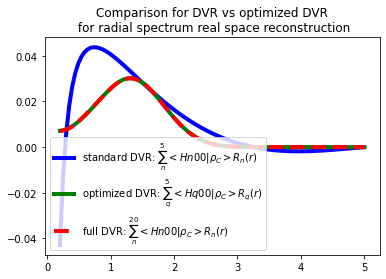

In [7]:
import matplotlib.pyplot as plt

plt.plot(
    radial_grid,
    real_space_radial_spectrum[i_env],
    color="b",
    lw=4,
    label="standard DVR: $\sum_n^{" + str(max_radial) + "} <H n00|ρ_C> R_n(r)$",
)
plt.plot(
    radial_grid,
    real_space_optimized_radial_spectrum[i_env],
    color="g",
    lw=4,
    label="optimized DVR: $\sum_q^{" + str(max_radial) + "} <H q00|ρ_C> R_q(r)$",
)
plt.plot(
    radial_grid,
    real_space_full_radial_spectrum[i_env],
    color="r",
    linestyle="--",
    lw=4,
    label="full DVR: $\sum_n^{" + str(expanded_max_radial) + "} <H n00|ρ_C> R_n(r)$",
)
plt.title(
    "Comparison for DVR vs optimized DVR\n for radial spectrum real space reconstruction"
)
plt.legend()
plt.show()
plt.close()

#### The full DVR real space radial spectrum can be better reconstructed with optimized DVR than with the standard DVR.